# EO over Ghana fields

In this notebook, we will show the Earth observation (EO) data over ground measurement fields and show how we interpret the satellite signals into variables (biophysical parameters) that closely describes the growth conditions of maize in the field. 

# Background

## Biophysical parameters

Biophysical, biochemical and phenological traits of plants are linked to the photosynthesis and nutrition processes during the growth cycle. They control response to the abiotic and biotic environmental filters, and in turn they feed back on the ecosystem and climate system through exchange of matter and energy cycle in the interaction between biosphere and atmosphere. Understanding traits and their co-variations lays a mechanistic foundation for quantitative and predictive analysis of planet ecology and change and can also help guide and refine functional ecosystem clustering. Modelling growth from a viewpoint of traits and their environmental interactions can provide a robust basis to link plants and ecosystem dynamics and ecosystem services such as the water, energy and other fluxes and help us to determine how climate and vegetation interact over a large range of timescales.

## Optical satellite measurements

Satellites like Sentibel 2 (S2) and Landsat-8 (L8) scan the Earth surface with optical sensors and the measurements are expressed as radiance or reflectance. But it is hard to link them directly to the crops growing status in the field. Traditionally, regression analysis can be used to build empirical relationships between variables expressing the crop growth conditions to the reflectance/radiance or ratios like NDVI. But those empirical relationships can be hardly extrapolated spatially or temporally. 

## Radiative transfer models

To systematically and physically interpret those satellite measurements, more advanced radiative transfer theory, physically expressing the satellite signal as a function of biophysical parameters, is normally used. With reasonable simplification and approximation of the canopy of crops, radiative transfer models are able to forward model the satellite measurements with different combinations of biophysical parameters. In this project, one of the mostly studied 1D canopy radiative transfer model is used to helps us to interpret the satellite signals. It consists of a leaf model PROSPECT and a canopy bidirectional reflectance model, SAIL (Scattering by Arbitrary Inclined Leaves), and the coupling of those two helps us the simulate satellite signals as a set of leaf parameters and canopy structure parameters. It mainly includes following parameters:

| Traits type        | Parameter                        | Symbol      | Range      | Unit         |
|--------------------|----------------------------------|-------------|------------|--------------|
| Canopy structure   | leaf area index                  | $LAI$       | 0-8        | m²/m²        |
|                    | leaf angle distribution function | $ALA$       | 0-90       | $^{\circ} $  |
|--------------------|----------------------------------|-------------|------------|--------------|
| Leaf optical       | chlorophyll a and b content      | $C_{ab}$    | 0-120      | $\mu g/cm^2$ |
|                    | Carotenoid content               | $C_{ar}$    | 0-25       | $\mu g/cm^2$ |
|                    | Anthocyanin content              | $C_{an}$    | 0          | $\mu g/cm^2$ |
|                    | leaf dry matter per leaf area    | $C_{m}$     | 0.002-0.02 | $\mu g/cm^2$ |
|                    | leaf water content per leaf area | $C_{w}$     | 0-0.04     | mg/cm²       |
|                    | brown pigment content            | $C_{brown}$ | 0-1        | -            |
|                    | mesophyll structure coefficient  | $N$         | 1-2.5      | -            |
|--------------------|----------------------------------|-------------|------------|--------------|
| angles             | solar zenith angle               | sza         | 0-80       | $^{\circ} $  |
|                    | viewing zenith angle             | vza         | 0-15       | $^{\circ} $  |
|                    | relative azimuth angle           | raa         | 0-360      | $^{\circ} $  |


## Time series satellite signal interpretation

Normally, time series of satellite signals are used to analysis the growth behaviour rather than individual date's observations. We can easily apply our radiative transfer model to any date's observation and try to invert those parameters using different methods, such as minimizing a cost function expressing the difference between the model simulated spectra and the satellite measurements, or machine learning methods, create a response function from the modelled reflectance to the individual parameters. Many studies have shown a certain level of accuracy can be achieved, but normally there are issues in inverting those parameters having smaller effects on the modelled spectra. This is normally attributed to either lack of enough observation information to constrain the inverse problem or the confounding effects in the radiative transfer model, i.e. different combination of bio-physical parameters generating spectra that are almost identical. Normally, prior information are used to better constrain the problem, which can be derived from different products, preivous studies and so on. 

In this demonstration, we uses prior information derived from China and US and they describe the typical temporal evolution of biophysical parameters throughout the crop growing season. We call them the archetypes of biophysical parameters. It contains the temporal changes of biophysical parameters, which are superiour than the normal constant values or range of values with uniform or Gaussian distributions. With additional four phenology parameters and 7 scaling parameters, we can simulate all kinds of growing behaviour of crops, to mimic crop growth under different conditions.



Feng - calibration of lai etc from the EO. That’s done really well for a first pass, but think about how it could be refined. How about fitting to VIs as well as reflectance? Does that help at all to narrow the posteriors? What about a 2-pass sampling we discussed? What about looking more at individual pixels in the field. How much variation is there?
Feng - Obv an empirical model between your parameters and yield would be interesting- see if the relationship could be predicted from your US calibration or vice-versa? But maybe they measure yield differently. See how well-constrained a max-lai and phenology prediction for yield is. 

In [31]:
from osgeo import ogr
fields = 'data/Biophysical_Data_Collection_Polygons_V1.geojson'

g = ogr.Open(fields)
l = g.GetLayer(0)
l.GetFeatureCount

In [26]:
import folium
import requests
from osgeo import ogr
from pygeotile.tile import Tile

zoom = 17

fields = 'data/Biophysical_Data_Collection_Polygons_V1.geojson'

g = ogr.open(fields)



my_map = folium.Map(location=[9.386, -0.688], zoom_start=zoom)
tile = Tile.for_latitude_longitude(*my_map.location, zoom)
x, y = tile.tms

folium.TileLayer('openstreetmap').add_to(my_map)

for i in range(x-2, x+4):
    for j in range(y - 3, y + 4):
        tile = Tile.from_tms(i, j, zoom)
        url = "http://ecn.t3.tiles.virtualearth.net/tiles/a%s.png?g=1"%tile.quad_tree
        ul, br = tile.bounds
        folium.raster_layers.ImageOverlay(
            image=url,
            name='sample map',
            opacity=1,
            bounds=[[br.latitude, ul.longitude], [ul.latitude, br.longitude]],
            interactive=False,
            cross_origin=False,
            zindex=1,
        ).add_to(my_map)
        
folium.GeoJson('data/Biophysical_Data_Collection_Polygons_V1.geojson').add_to(my_map)
my_map

In [1]:
import os
import sys
import numpy as np
import requests
import json
import datetime
from pygeotile.tile import Tile
from shapely import geometry
from bqplot import Lines, Figure, LinearScale, DateScale, Axis
from ipywidgets import Dropdown, FloatSlider, HBox, VBox, Layout, Label, jslink, Layout, SelectionSlider, Play
from ipyleaflet import Map, WidgetControl, LayersControl, ImageOverlay, GeoJSON, Marker, Icon
from ipywidgets import Image as ImageWidget
sys.path.insert(0, './python/')
from map_utils import get_lai_gif, get_pixel, get_field_bounds, da_pix

zoom = 17


defaultLayout=Layout(width='100%', height='540px')
my_map = Map(center=(9.3771, -0.6062), zoom=zoom, scroll_wheel_zoom=True, max_zoom = 19, layout=defaultLayout)



with open('./data/Biophysical_Data_Collection_Polygons_V1.geojson', 'r') as f:
    data = json.load(f)
field_ids = [feat['properties']['Field_ID'] for feat in data['features']]

dropdown = Dropdown(
    options=field_ids,
    value=field_ids[0],
    description="Field ID:",
)
field_id = field_ids[0]

field_bounds, doys = get_field_bounds(field_id)


poly = geometry.Polygon(data['features'][0]['geometry']['coordinates'][0])
my_map.center = (poly.centroid.y, poly.centroid.x)


x_scale = LinearScale(min = 200, max = 365)
y_scale = LinearScale(min = 0, max = 3)
x = np.arange(200, 365)
y = np.zeros_like(x)

lines = Lines(x=x, y=y, scales={"x": x_scale, "y": y_scale})

tick_style = {'font-size': 8}
ax_x = Axis(label="DOY", scale=x_scale, num_ticks=5, tick_style=tick_style)
ax_y = Axis(label='LAI', scale=y_scale, orientation="vertical", side="left", num_ticks=4, tick_style=tick_style)

figure = Figure(
    axes=[ax_x, ax_y],
    title=field_id,
    marks=[lines],
    animation_duration=500,
    layout={"max_height": "250px", "max_width": "400px"},
)

# widget_control1 = WidgetControl(widget=figure, position="bottomright")
# my_map.add_control(widget_control1)


line = Lines(x=x, y=y, scales={"x": x_scale, "y": y_scale})

fig_layout = Layout(width='auto', height='auto', max_height='120px', max_width='180px')
#fig_layout = Layout(width='1%', height='20%')

figy=[]
for i in range(3):
    figx=[]
    for j in range(2):
        fig = Figure(layout=fig_layout, axes=[ax_x, ax_y], marks=[line], 
                           title=field_id, 
                           animation_duration=500, 
                           title_style = {'font-size': '8'},
                           fig_margin = dict(top=16, bottom=16, left=16, right=16))
        fig.title = field_id
        figx.append(fig)
    figy.append(HBox(figx))
widget_control2 = WidgetControl(widget=VBox(figy, align_content = 'stretch'), position='topright')
# my_map.add_control(widget_control2)



fig_layout = Layout(width='auto', height='auto', max_height='120px', max_width='180px')
#fig_layout = Layout(width='1%', height='20%')

doys = np.arange(200, 365)
sels = np.zeros((6, len(doys), 10))

tick_style = {'font-size': 8}
names = ['B1', 'B2', 'B3', 'B4', 'Cab', 'Lai']
line_axs = []
for ii in range(6):
    y_scale = LinearScale(min = sels[ii].T.min(), max = sels[ii].T.max())
    ax_x = Axis(label="DOY", scale=x_scale, num_ticks=5, tick_style=tick_style)
    ax_y = Axis(label=names[ii], scale=y_scale, orientation="vertical", side="left", num_ticks=4, tick_style=tick_style)
    line = Lines(x=doys, y=sels[ii].T, scales={"x": x_scale, "y": y_scale})
    line.colors = ['#81d8d0']
    line.stroke_width = 0.1
    line_axs.append([line, ax_x, ax_y])

ref_lines = []

for ii in range(4):
    line, ax_x, ax_y = line_axs[ii]
    ref_line = Lines(x=doys, y=np.ones_like(doys) * np.nan, scales = line.scales, line_style='dotted', marker='circle', marker_size=4, colors = ['#c0c0c0'])
    ref_lines.append(ref_line)

good_ref_lines = []
line_colors = ['#3399ff', '#008000', '#ff6666', '#990000']
for ii in range(4):
    line, ax_x, ax_y = line_axs[ii]
    good_ref_line = Lines(x=doys, y=np.ones_like(doys) * np.nan, scales = line.scales, line_style='dotted', marker='circle', marker_size=4, colors = [line_colors[ii]])
    good_ref_lines.append(good_ref_line)
    
figy=[]
for i in range(3):
    figx=[]
    for j in range(2):
        if i*2+j < 4:
            ref_line = ref_lines[i*2+j]
            good_ref_line = good_ref_lines[i*2+j]
            line, ax_x, ax_y = line_axs[i*2+j]
            fig = Figure(layout=fig_layout, axes=[ax_x, ax_y], marks=[line, ref_line, good_ref_line], 
                               title=field_id, 
                               animation_duration=500, 
                               title_style = {'font-size': '8'},
                               fig_margin = dict(top=16, bottom=16, left=16, right=16))

        else:
            line, ax_x, ax_y = line_axs[i*2+j]
            var_line = Lines(x=doys, y=np.zeros_like(doys), scales = line.scales)
            line_axs.append(var_line)
            fig = Figure(layout=fig_layout, axes=[ax_x, ax_y], marks=[line, var_line], 
                               title=field_id, 
                               animation_duration=500, 
                               title_style = {'font-size': '8'},
                               fig_margin = dict(top=16, bottom=16, left=16, right=16))

        fig.title = names[i*2+j]
        figx.append(fig)
    figy.append(HBox(figx))
# display(VBox(figy, align_content = 'stretch'))

fig_box = VBox(figy, align_content = 'stretch')
# widget_control1 = WidgetControl(widget=VBox(figy, align_content = 'stretch'), position='topright')

box_layout = Layout(display='flex',
                flex_flow='column',
                align_items='center',
                width='100%')

k_slider = FloatSlider(min=0, max=6, value=2,        # Opacity is valid in [0,1] range
               orientation='horizontal',       # Vertical slider is what we want
               readout=True,                # No need to show exact value
               layout=Layout(width='80%'),
               description='K: ', 
               style={'description_width': 'initial'}) 

panel_box = VBox([fig_box, k_slider], layout = box_layout)

widget_control1 = WidgetControl(widget=panel_box, position='topright')
my_map.add_control(widget_control1)

            

slider = FloatSlider(min=0, max=1, value=1,        # Opacity is valid in [0,1] range
               orientation='vertical',       # Vertical slider is what we want
               readout=False,                # No need to show exact value
               layout=Layout(width='2em')) # Fine tune display layout: make it thinner
my_map.add_control(WidgetControl(widget=slider))

tile = Tile.for_latitude_longitude(*my_map.center, zoom)
x, y = tile.tms

for i in range(x-3, x + 4):
    for j in range(y - 3, y + 4):
        tile = Tile.from_tms(i, j, zoom)
        url = "http://ecn.t3.tiles.virtualearth.net/tiles/a%s.png?g=1"%tile.quad_tree
        ul, br = tile.bounds
        image = ImageOverlay(
            url=url,
            bounds = tile.bounds,
            name = 'bing_basemap_%d'%zoom
        )
        my_map.add_layer(image)  
        
        
def on_change_zoom(change):
    if change['type'] == 'change' and change['name'] == 'zoom':
        zoom = int(my_map.zoom)
        tile = Tile.for_latitude_longitude(*my_map.center, zoom)
        x, y = tile.tms
        

        for i in range(x- 3, x + 4):
            for j in range(y - 2, y + 3):
                tile = Tile.from_tms(i, j, zoom)
                url = "http://ecn.t3.tiles.virtualearth.net/tiles/a%s.png?g=1"%tile.quad_tree

                image = ImageOverlay(
                    url=url,
                    bounds = tile.bounds,
                    name = 'bing_basemap_%d'%zoom
                )
                my_map.add_layer(image)   

        for layer in my_map.layers:
            if layer.name == 'bing_basemap_%d'%int(change['old']):
                my_map.remove_layer(layer)
        
# my_map.observe(on_change_zoom)


field_movie = None
daily_img = None
def on_click(change):
    global field_id
    global field_bounds
    global doys
    global field_movie
    field_id = change["new"]
    
    ind = field_ids.index(field_id)
    
    feature = data['features'][ind]
    poly = geometry.Polygon(feature['geometry']['coordinates'][0])
    lon, lat = poly.centroid.coords[0]
    my_map.center = lat, lon
    zoom = 17
    tile = Tile.for_latitude_longitude(*my_map.center, zoom)
    x, y = tile.tms
    
    

    for i in range(x- 3, x + 4):
        for j in range(y - 2, y + 3):
            tile = Tile.from_tms(i, j, zoom)
            url = "http://ecn.t3.tiles.virtualearth.net/tiles/a%s.png?g=1"%tile.quad_tree
            image = ImageOverlay(
                url=url,
                bounds = tile.bounds,
                name = 'bing_basemap_%d'%zoom
            )
            my_map.add_layer(image)   
    print(field_id)
    play_label.value = 'Click to play movie over field: %s'%field_id
    home = os.getcwd()
    cwd = '/files/' + '/'.join(home.split('/')[3:])
    base_url = my_map.window_url.split('/lab/')[0] + cwd + '/'
    
    url, bounds, doys = get_lai_gif(field_id)
    dates = [(datetime.datetime(2021, 1, 1) + datetime.timedelta(days=int(i-1))).strftime('%Y-%m-%d') for i in doys]
    slider2.options = dates
    field_bounds = bounds
    url = base_url + url
    # print(url)
#     if field_movie is not None:
#         my_map.remove_layer(field_movie)
    
#     field_movie = ImageOverlay(
#         url=url,
#         bounds = bounds,
#         name = 'S2_%s_lai_movie'%(field_id)
#     )
    # my_map.add_layer(field_movie)
    global daily_img
    # if daily_img is None:
    #     print(url)
    #     print(field_bounds)
    #     print('S2_%s_lai_png'%(field_id))
    #     daily_img = ImageOverlay(
    #     url=url,
    #     bounds = field_bounds,
    #     name = 'S2_%s_lai_png'%(field_id)
    #     )
    #     my_map.add_layer(daily_img)
    #     daily_img.url = url
    #     daily_img.bounds = field_bounds
    # daily_img.bounds = field_bounds
    jslink((slider, 'value'), (daily_img, 'opacity') )
    
    
    #for layer in my_map.layers:
        #if layer.name == 'S2_%s_lai_movie'%field_id:
            # Connect slider value to opacity property of the Image Layer
            

dropdown.observe(on_click, "value")
widget_control3 = WidgetControl(widget=dropdown, position="bottomleft")
my_map.add_control(widget_control3)

def on_change_slider2(change):
    
    if (change['name'] == 'value') & (change['type'] == 'change'):
        value = change["new"]
        old = change['old']
        ind = change['owner'].index
        
        value = doys[ind]
        home = os.getcwd()
        cwd = '/files/' + '/'.join(home.split('/')[3:])
        base_url = my_map.window_url.split('/lab/')[0] + cwd + '/'
        
        url = 'data/S2_thumbs/S2_%s_lai_%03d.png'%(field_id, value)
        url = base_url + url
        field_bounds, _ = get_field_bounds(field_id)
        
#         if daily_img is not None:
#             my_map.remove_layer(daily_img)
            
#         daily_img = ImageOverlay(
#             url=url,
#             bounds = field_bounds,
#             name = 'S2_%s_lai_png'%(field_id)
#         )

#         my_map.add_layer(daily_img)
        global daily_img
        if daily_img is None:
            daily_img = ImageOverlay(
            url=url,
            bounds = field_bounds,
            name = 'S2_%s_lai_png'%(field_id)
            )
            my_map.add_layer(daily_img)
            daily_img.url = url
            daily_img.bounds = field_bounds
        else:
            daily_img.url = url
            daily_img.bounds = field_bounds
        # print(url)

play = Play(
    value=0,
    min=0,
    max=len(doys),
    step=1,
    interval=200,
    description="Press play",
    disabled=False
)

dates = [(datetime.datetime(2021, 1, 1) + datetime.timedelta(days=int(i-1))).strftime('%Y-%m-%d') for i in doys]
slider2 = SelectionSlider(options = dates, description='Date: ', style={'description_width': 'initial'}) 
slider2.observe(on_change_slider2)
# widget_control2 = WidgetControl(widget=slider2, position="bottomright")
jslink((play, 'value'), (slider2, 'index'))
# label = 
# display(label)
play_label = Label('Click to play movie over field: %s'%field_id)

play_box = HBox([play, slider2])
play_box = VBox([play_label, play_box])

widget_control2 = WidgetControl(widget=play_box, position="bottomright")
my_map.add_control(widget_control2)


def random_color(feature):
    return {
        'color': 'black',
        'fillColor': np.random.choice(['red', 'yellow', 'green', 'orange']),
    }

fields = GeoJSON(
    data=data,
    style={
        'opacity': 1, 'dashArray': '0', 'fillOpacity': 0, 'weight': 1
    },
    hover_style={
        'color': 'white', 'dashArray': '0', 'fillOpacity': 0
    },
    style_callback=random_color
)


with open('./data/Biophysical_Data_Collection_Points_V1.geojson', 'r') as f:
    data2 = json.load(f)
    
points = GeoJSON(
    data=data2,
    point_style={'radius': 5, 'color': 'blue', 'fillOpacity': 0.5, 'fillColor': 'blue', 'weight': 0.1},
    # style={
    #     'opacity': 1, 'dashArray': '0', 'fillOpacity': 0.2, 'weight': 0.01
    # },
    hover_style={
        'color': 'white', 'dashArray': '0', 'fillOpacity': 1
    },
    # style_callback=random_color
)



label = Label()
display(label)

marker = None

def handle_interaction(**kwargs):
    # if kwargs.get('type') == 'mousemove':
    #     label.value = str(kwargs.get('coordinates'))
    if kwargs.get('type') == 'click':
        
        location=kwargs.get('coordinates')
        # print(location)
        point = geometry.Point(location[1], location[0])
        
        ind = field_ids.index(field_id)
        feature = data['features'][ind]
        poly = geometry.Polygon(feature['geometry']['coordinates'][0])
        
        if poly.contains(point):    
            label.value = 'Maize planted in field: %s'%field_id
            # global marker
            # if marker is not None:
            #     my_map.remove_layer(marker)
            # marker = Marker(location=location)
            
            global sels, planet_sur, doys
            doys, pix_lai, pix_cab, sels, lais, planet_sur = get_pixel(location, field_id)
            
            mean_ref, mean_bios, std_ref, std_bios, sel_inds, u_mask = da_pix(sels, planet_sur, u_thresh = k_slider.value)
            
            show_inds = np.random.choice(range(200), 50)
            sels_to_show = sels[:, :, show_inds]
            
            pix_cab, pix_lai = mean_bios
            
            max_ind = np.argmax(pix_lai)
            
            field_max = lais[:, max_ind].max()
            field_min = lais[:, max_ind].min() 
            
            lai_ratio = (pix_lai.max() - field_min) / (field_max - field_min)
            # print(field_max, field_min)
            # print(lai_ratio)
            
            icon = Icon(icon_url='https://leafletjs.com/examples/custom-icons/leaf-green.png', icon_size=[(38*lai_ratio), int(95*lai_ratio)], icon_anchor=[22,94])
            icon = Icon(icon_url='https://gws-access.jasmin.ac.uk/public/nceo_ard/Ghana/Ghana_workshop2022/imgs/maize.png', 
                        icon_size=[int(38*lai_ratio), int(95*lai_ratio)], 
                        icon_anchor=[int(22*lai_ratio),int(94*lai_ratio)])
            
            marker = Marker(location=location, icon=icon, rotation_angle=0, rotation_origin='22px 94px')

            my_map.add_layer(marker)                        
            


            sels_to_show = sels[:, :, sel_inds]
            for ii in range(6):
                line, ax_x, ax_y = line_axs[ii]
                y_scale = LinearScale(min = sels_to_show[ii].T.min(), max = sels_to_show[ii].T.max())
                ax_y.scale = y_scale
                line.x = doys
                line.y = sels_to_show[ii].T
                line.scales = {"x": x_scale, "y": y_scale}
                
            var_line = line_axs[-2]
            var_line.x = doys
            var_line.y = pix_cab
            var_line.scales = line_axs[4][0].scales
            
            var_line = line_axs[-1]
            var_line.x = doys
            var_line.y = pix_lai
            var_line.scales = line_axs[5][0].scales
            
            for ii in range(4):
                line, ax_x, ax_y = line_axs[ii]
                ref_line = ref_lines[ii]
                ref_line.scales = line.scales
                ref_line.x = doys[~u_mask]
                ref_line.y = planet_sur[ii][~u_mask]
            
            # print(planet_sur.shape, u_mask.shape)
            for ii in range(4):
                line, ax_x, ax_y = line_axs[ii]
                good_ref_line = good_ref_lines[ii]
                good_ref_line.scales = line.scales
                good_ref_line.x = doys[u_mask]
                good_ref_line.y = planet_sur[ii][u_mask]
                
        else:
            label.value = 'Not in field: %s'%field_id
            # print('Not in field: %s'%field_id)


def on_change_k_slider(change):
    
    if (change['name'] == 'value') & (change['type'] == 'change'):
        value = change["new"]
        old = change['old']
        mean_ref, mean_bios, std_ref, std_bios, sel_inds, u_mask = da_pix(sels.copy(), planet_sur.copy(), u_thresh = value)

        show_inds = np.random.choice(range(200), 50)
        sels_to_show = sels[:, :, show_inds]

        

        sels_to_show = sels[:, :, sel_inds]
        for ii in range(6):
            line, ax_x, ax_y = line_axs[ii]
            y_scale = LinearScale(min = sels_to_show[ii].T.min(), max = sels_to_show[ii].T.max())
            # ax_y.scale = y_scale
            ax_y.scale = ax_y.scale
            line.x = doys
            line.y = sels_to_show[ii].T
            line.scales = {"x": x_scale, "y": y_scale}

        pix_cab, pix_lai = mean_bios
        
        var_line = line_axs[-2]
        var_line.x = doys
        var_line.y = pix_cab
        var_line.scales = line_axs[4][0].scales

        var_line = line_axs[-1]
        var_line.x = doys
        var_line.y = pix_lai
        var_line.scales = line_axs[5][0].scales

        for ii in range(4):
            line, ax_x, ax_y = line_axs[ii]
            ref_line = ref_lines[ii]
            ref_line.scales = line.scales
            ref_line.x = doys[~u_mask]
            ref_line.y = planet_sur[ii][~u_mask]

        # print(planet_sur.shape, u_mask.shape)
        for ii in range(4):
            line, ax_x, ax_y = line_axs[ii]
            good_ref_line = good_ref_lines[ii]
            good_ref_line.scales = line.scales
            good_ref_line.x = doys[u_mask]
            good_ref_line.y = planet_sur[ii][u_mask]

k_slider.observe(on_change_k_slider)

my_map.on_interaction(handle_interaction)
my_map.add_layer(fields)
my_map.add_layer(points)
control = LayersControl(position='topleft')
my_map.add_control(control)

my_map

Label(value='')

Map(center=[9.700554008484533, -0.541705192919114], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [4]:

def da_pix(sels, planet_sur, u_thresh = 2):
    sel_s2_refs_med = np.nanmedian(sels[:4], axis=2) 
    residuals = planet_sur - sel_s2_refs_med
    residuals_abs = abs(residuals)
    MAD = np.nanmedian(residuals_abs, axis=1)
    S = MAD /  0.6745
    u = residuals_abs / S[:, None]
    u_mask = (u <= u_thresh).all(axis=0)

    sel_s2_refs = sels[:4, u_mask]
    s2_sur = planet_sur[:, u_mask]
    s2_sur_unc = planet_sur[:, u_mask] * 0.10


    # s2_sur[~u_mask] = np.nan

    diff = (s2_sur[:, :, None] - sel_s2_refs)
    diff = np.nansum(diff**2 * s2_sur_unc[:, :, None]**2, axis=(0,1))
    inds = np.argsort(diff)

    sel_nums = 10
    sel_inds = inds[:sel_nums]
    diff = diff[inds][:sel_nums]

    weight = 1 / diff
    # weight = np.exp(-1 * diff / 2)

    weight = weight / weight.sum()

    mean_ref        = np.sum(sel_s2_refs[:, :, sel_inds] * weight[None, None], axis=2) 
    mean_bios       = np.sum(sels[4:][:, :, sel_inds] * weight[None, None], axis=2)

    correction = sel_nums / (sel_nums - 1)
    weight = weight * correction

    std_ref        = np.sqrt(np.sum((sel_s2_refs[:, :, sel_inds] - mean_ref [:, :, None])**2 * weight[None, None], axis=2))
    std_bios       = np.sqrt(np.sum((sels[4:][:, :, sel_inds] - mean_bios[:, :, None])**2 * weight[None, None], axis=2))

    return mean_ref, mean_bios, std_ref, std_bios

In [3]:
import os
import sys
import numpy as np
import requests
import json
import datetime
from pygeotile.tile import Tile
from shapely import geometry
from bqplot import Lines, Figure, LinearScale, DateScale, Axis
from ipywidgets import Dropdown, FloatSlider, HBox, VBox, Layout, Label, jslink, Layout, SelectionSlider, Play
from ipyleaflet import Map, WidgetControl, LayersControl, ImageOverlay, GeoJSON, Marker, Icon
sys.path.insert(0, './python/')
from map_utils import get_lai_gif, get_pixel, get_field_bounds, da_pix

from ipywidgets import Image as ImageWidget
# import IPython
# url = 'https://gws-access.jasmin.ac.uk/public/nceo_ard/Ghana/Ghana_workshop2022/imgs/maize.png'
# maize_img_data = IPython.display.Image(url, width = 300)
# maize_img = ImageWidget(
#   value=maize_img_data.data,
#   format='Png', 
#   width='20',
#   height='20',
# )

zoom = 17


defaultLayout=Layout(width='100%', height='540px')
my_map = Map(center=(9.3771, -0.6062), zoom=zoom, scroll_wheel_zoom=True, max_zoom = 19, layout=defaultLayout)



with open('./data/Biophysical_Data_Collection_Polygons_V1.geojson', 'r') as f:
    data = json.load(f)
field_ids = [feat['properties']['Field_ID'] for feat in data['features']]

dropdown = Dropdown(
    options=field_ids,
    value=field_ids[0],
    description="Field ID:",
)
field_id = field_ids[0]

field_bounds, doys = get_field_bounds(field_id)


poly = geometry.Polygon(data['features'][0]['geometry']['coordinates'][0])
my_map.center = (poly.centroid.y, poly.centroid.x)


x_scale = LinearScale(min = 200, max = 365)
y_scale = LinearScale(min = 0, max = 3)
x = np.arange(200, 365)
y = np.zeros_like(x)

lines = Lines(x=x, y=y, scales={"x": x_scale, "y": y_scale})

tick_style = {'font-size': 8}
ax_x = Axis(label="DOY", scale=x_scale, num_ticks=5, tick_style=tick_style)
ax_y = Axis(label='LAI', scale=y_scale, orientation="vertical", side="left", num_ticks=4, tick_style=tick_style)

figure = Figure(
    axes=[ax_x, ax_y],
    title=field_id,
    marks=[lines],
    animation_duration=500,
    layout={"max_height": "250px", "max_width": "400px"},
)

# widget_control1 = WidgetControl(widget=figure, position="bottomright")
# my_map.add_control(widget_control1)


line = Lines(x=x, y=y, scales={"x": x_scale, "y": y_scale})

fig_layout = Layout(width='auto', height='auto', max_height='120px', max_width='180px')
#fig_layout = Layout(width='1%', height='20%')

figy=[]
for i in range(3):
    figx=[]
    for j in range(2):
        fig = Figure(layout=fig_layout, axes=[ax_x, ax_y], marks=[line], 
                           title=field_id, 
                           animation_duration=500, 
                           title_style = {'font-size': '8'},
                           fig_margin = dict(top=16, bottom=16, left=16, right=16))
        fig.title = field_id
        figx.append(fig)
    figy.append(HBox(figx))
widget_control2 = WidgetControl(widget=VBox(figy, align_content = 'stretch'), position='topright')
# my_map.add_control(widget_control2)



fig_layout = Layout(width='auto', height='auto', max_height='120px', max_width='180px')
#fig_layout = Layout(width='1%', height='20%')

# doys = np.arange(200, 365)
sels = np.zeros((6, len(doys), 10))

tick_style = {'font-size': 8}
names = ['B1', 'B2', 'B3', 'B4', 'Cab', 'Lai']
line_axs = []
for ii in range(6):
    y_scale = LinearScale(min = sels[ii].T.min(), max = sels[ii].T.max())
    ax_x = Axis(label="DOY", scale=x_scale, num_ticks=5, tick_style=tick_style)
    ax_y = Axis(label=names[ii], scale=y_scale, orientation="vertical", side="left", num_ticks=4, tick_style=tick_style)
    line = Lines(x=doys, y=sels[ii].T, scales={"x": x_scale, "y": y_scale})
    line.colors = ['#81d8d0']
    line.stroke_width = 0.1
    line_axs.append([line, ax_x, ax_y])

ref_lines = []

for ii in range(4):
    line, ax_x, ax_y = line_axs[ii]
    ref_line = Lines(x=doys, y=np.ones_like(doys) * np.nan, scales = line.scales, line_style='dotted', marker='circle', marker_size=4, colors = ['#c0c0c0'])
    ref_lines.append(ref_line)

good_ref_lines = []
line_colors = ['#3399ff', '#008000', '#ff6666', '#990000']
for ii in range(4):
    line, ax_x, ax_y = line_axs[ii]
    good_ref_line = Lines(x=doys, y=np.ones_like(doys) * np.nan, scales = line.scales, line_style='dotted', marker='circle', marker_size=4, colors = [line_colors[ii]])
    good_ref_lines.append(good_ref_line)
    
figy=[]
for i in range(3):
    figx=[]
    for j in range(2):
        if i*2+j < 4:
            ref_line = ref_lines[i*2+j]
            good_ref_line = good_ref_lines[i*2+j]
            line, ax_x, ax_y = line_axs[i*2+j]
            fig = Figure(layout=fig_layout, axes=[ax_x, ax_y], marks=[line, ref_line, good_ref_line], 
                               title=field_id, 
                               animation_duration=500, 
                               title_style = {'font-size': '8'},
                               fig_margin = dict(top=16, bottom=16, left=16, right=16))

        else:
            line, ax_x, ax_y = line_axs[i*2+j]
            var_line = Lines(x=doys, y=np.zeros_like(doys), scales = line.scales)
            line_axs.append(var_line)
            fig = Figure(layout=fig_layout, axes=[ax_x, ax_y], marks=[line, var_line], 
                               title=field_id, 
                               animation_duration=500, 
                               title_style = {'font-size': '8'},
                               fig_margin = dict(top=16, bottom=16, left=16, right=16))

        fig.title = names[i*2+j]
        figx.append(fig)
    figy.append(HBox(figx))
# display(VBox(figy, align_content = 'stretch'))

fig_box = VBox(figy, align_content = 'stretch')
# widget_control1 = WidgetControl(widget=VBox(figy, align_content = 'stretch'), position='topright')

box_layout = Layout(display='flex',
                flex_flow='column',
                align_items='center',
                width='100%')

k_slider = FloatSlider(min=0, max=6, value=2,        # Opacity is valid in [0,1] range
               orientation='horizontal',       # Vertical slider is what we want
               readout=True,                # No need to show exact value
               layout=Layout(width='80%'),
               description='K: ', 
               style={'description_width': 'initial'}) 

panel_box = VBox([fig_box, k_slider], layout = box_layout)

widget_control1 = WidgetControl(widget=panel_box, position='topright')
my_map.add_control(widget_control1)

            

slider = FloatSlider(min=0, max=1, value=1,        # Opacity is valid in [0,1] range
               orientation='vertical',       # Vertical slider is what we want
               readout=False,                # No need to show exact value
               layout=Layout(width='2em')) # Fine tune display layout: make it thinner
my_map.add_control(WidgetControl(widget=slider))

tile = Tile.for_latitude_longitude(*my_map.center, zoom)
x, y = tile.tms

for i in range(x-3, x + 4):
    for j in range(y - 3, y + 4):
        tile = Tile.from_tms(i, j, zoom)
        url = "http://ecn.t3.tiles.virtualearth.net/tiles/a%s.png?g=1"%tile.quad_tree
        ul, br = tile.bounds
        image = ImageOverlay(
            url=url,
            bounds = tile.bounds,
            name = 'bing_basemap_%d'%zoom
        )
        my_map.add_layer(image)  
        
        
def on_change_zoom(change):
    if change['type'] == 'change' and change['name'] == 'zoom':
        zoom = int(my_map.zoom)
        tile = Tile.for_latitude_longitude(*my_map.center, zoom)
        x, y = tile.tms
        

        for i in range(x- 3, x + 4):
            for j in range(y - 2, y + 3):
                tile = Tile.from_tms(i, j, zoom)
                url = "http://ecn.t3.tiles.virtualearth.net/tiles/a%s.png?g=1"%tile.quad_tree

                image = ImageOverlay(
                    url=url,
                    bounds = tile.bounds,
                    name = 'bing_basemap_%d'%zoom
                )
                my_map.add_layer(image)   

        for layer in my_map.layers:
            if layer.name == 'bing_basemap_%d'%int(change['old']):
                my_map.remove_layer(layer)
        
# my_map.observe(on_change_zoom)


field_movie = None
daily_img = None
def on_click(change):
    global field_id
    global field_bounds
    global doys
    global field_movie
    field_id = change["new"]
    
    ind = field_ids.index(field_id)
    
    feature = data['features'][ind]
    poly = geometry.Polygon(feature['geometry']['coordinates'][0])
    lon, lat = poly.centroid.coords[0]
    my_map.center = lat, lon
    zoom = 17
    tile = Tile.for_latitude_longitude(*my_map.center, zoom)
    x, y = tile.tms
    
    

    for i in range(x- 3, x + 4):
        for j in range(y - 2, y + 3):
            tile = Tile.from_tms(i, j, zoom)
            url = "http://ecn.t3.tiles.virtualearth.net/tiles/a%s.png?g=1"%tile.quad_tree
            image = ImageOverlay(
                url=url,
                bounds = tile.bounds,
                name = 'bing_basemap_%d'%zoom
            )
            my_map.add_layer(image)   
    print(field_id)
    play_label.value = 'Click to play movie over field: %s'%field_id
    home = os.getcwd()
    cwd = '/files/' + '/'.join(home.split('/')[3:])
    base_url = my_map.window_url.split('/lab/')[0] + cwd + '/'
    
    url, bounds, doys = get_lai_gif(field_id)
    dates = [(datetime.datetime(2021, 1, 1) + datetime.timedelta(days=int(i-1))).strftime('%Y-%m-%d') for i in doys]
    slider2.options = dates
    field_bounds = bounds
    url = base_url + url
    # print(url)
#     if field_movie is not None:
#         my_map.remove_layer(field_movie)
    
#     field_movie = ImageOverlay(
#         url=url,
#         bounds = bounds,
#         name = 'S2_%s_lai_movie'%(field_id)
#     )
    # my_map.add_layer(field_movie)
    global daily_img
    if daily_img is None:
        # print(url)
        # print(field_bounds)
        # print('S2_%s_lai_png'%(field_id))
        daily_img = ImageOverlay(
        url=url,
        bounds = field_bounds,
        name = 'S2_%s_lai_png'%(field_id)
        )
        my_map.add_layer(daily_img)
        daily_img.url = url
        daily_img.bounds = field_bounds
    else:
        my_map.remove_layer(daily_img)
        daily_img = ImageOverlay(
            url=url,
            bounds = field_bounds,
            name = 'S2_%s_lai_png'%(field_id)
        )
        my_map.add_layer(daily_img)
        # daily_img.url = url
        # daily_img.bounds = field_bounds
    
    jslink((slider, 'value'), (daily_img, 'opacity') )
    
    
    #for layer in my_map.layers:
        #if layer.name == 'S2_%s_lai_movie'%field_id:
            # Connect slider value to opacity property of the Image Layer
            

dropdown.observe(on_click, "value")
widget_control3 = WidgetControl(widget=dropdown, position="bottomleft")
my_map.add_control(widget_control3)

def on_change_slider2(change):
    
    if (change['name'] == 'value') & (change['type'] == 'change'):
        value = change["new"]
        old = change['old']
        ind = change['owner'].index
        
        value = doys[ind]
        home = os.getcwd()
        cwd = '/files/' + '/'.join(home.split('/')[3:])
        base_url = my_map.window_url.split('/lab/')[0] + cwd + '/'
        
        url = 'data/S2_thumbs/S2_%s_lai_%03d.png'%(field_id, value)
        url = base_url + url
        field_bounds, _ = get_field_bounds(field_id)
        
#         if daily_img is not None:
#             my_map.remove_layer(daily_img)
            
#         daily_img = ImageOverlay(
#             url=url,
#             bounds = field_bounds,
#             name = 'S2_%s_lai_png'%(field_id)
#         )

#         my_map.add_layer(daily_img)
        # my_map.remove_layer(maize_marker) 
        
        # maize_marker.icon.icon_size = [(38*lai_ratio), int(95*lai_ratio)]
        if maize_marker is not None:
            lai_ratio = (pix_lai[ind] - 0) / (field_max - 0)
            
            maize_icon = Icon(icon_url='https://gws-access.jasmin.ac.uk/public/nceo_ard/Ghana/Ghana_workshop2022/imgs/maize.png', 
                        icon_size=[36.5*lai_ratio, 98.5*lai_ratio], 
                        icon_anchor=[36.5/2*lai_ratio, 98.5*lai_ratio])
            maize_marker.icon = maize_icon
        # maize_marker.icon.icon_size=[38*lai_ratio, 95*lai_ratio] 
        # maize_marker.icon.icon_anchor=[22*lai_ratio,94*lai_ratio]
        # my_map.add_layer(maize_marker) 
        # print(maize_icon)   
        # print(lai_ratio)
        global daily_img
        if daily_img is None:
            daily_img = ImageOverlay(
            url=url,
            bounds = field_bounds,
            name = 'S2_%s_lai_png'%(field_id)
            )
            my_map.add_layer(daily_img)
            daily_img.url = url
            daily_img.bounds = field_bounds
        else:
            daily_img.url = url
            daily_img.bounds = field_bounds
        # print(url)

play = Play(
    value=0,
    min=0,
    max=len(doys),
    step=1,
    interval=200,
    description="Press play",
    disabled=False
)

dates = [(datetime.datetime(2021, 1, 1) + datetime.timedelta(days=int(i-1))).strftime('%Y-%m-%d') for i in doys]
slider2 = SelectionSlider(options = dates, description='Date: ', style={'description_width': 'initial'}) 
slider2.observe(on_change_slider2)
# widget_control2 = WidgetControl(widget=slider2, position="bottomright")
jslink((play, 'value'), (slider2, 'index'))
# label = 
# display(label)
play_label = Label('Click to play movie over field: %s'%field_id)
# label_box = HBox([play_label, maize_img], align_content = 'stretch', layout=Layout(width='100%', height='50%'))
play_box = HBox([play, slider2])
play_box = VBox([play_label, play_box])

widget_control2 = WidgetControl(widget=play_box, position="bottomright")
my_map.add_control(widget_control2)


def random_color(feature):
    return {
        'color': 'black',
        'fillColor': np.random.choice(['red', 'yellow', 'green', 'orange']),
    }

fields = GeoJSON(
    data=data,
    style={
        'opacity': 1, 'dashArray': '0', 'fillOpacity': 0, 'weight': 1
    },
    hover_style={
        'color': 'white', 'dashArray': '0', 'fillOpacity': 0
    },
    style_callback=random_color
)


with open('./data/Biophysical_Data_Collection_Points_V1.geojson', 'r') as f:
    data2 = json.load(f)
    
points = GeoJSON(
    data=data2,
    point_style={'radius': 5, 'color': 'blue', 'fillOpacity': 0.5, 'fillColor': 'blue', 'weight': 0.1},
    # style={
    #     'opacity': 1, 'dashArray': '0', 'fillOpacity': 0.2, 'weight': 0.01
    # },
    hover_style={
        'color': 'white', 'dashArray': '0', 'fillOpacity': 1
    },
    # style_callback=random_color
)



label = Label()
display(label)

maize_marker = None
pix_lai = None
maize_icon = None
def handle_interaction(**kwargs):
    # if kwargs.get('type') == 'mousemove':
    #     label.value = str(kwargs.get('coordinates'))
    if kwargs.get('type') == 'click':
        
        location=kwargs.get('coordinates')
        # print(location)
        point = geometry.Point(location[1], location[0])
        
        ind = field_ids.index(field_id)
        feature = data['features'][ind]
        poly = geometry.Polygon(feature['geometry']['coordinates'][0])
        
        if poly.contains(point):    
            label.value = 'Maize planted in field: %s'%field_id
            # global marker
            # if marker is not None:
            #     my_map.remove_layer(marker)
            # marker = Marker(location=location)
            
            global sels, planet_sur, doys
            global maize_icon, pix_lai, field_max, field_min, maize_marker
            doys, pix_lai, pix_cab, sels, lais, planet_sur = get_pixel(location, field_id)
            
            mean_ref, mean_bios, std_ref, std_bios, sel_inds, u_mask = da_pix(sels, planet_sur, u_thresh = k_slider.value)
            
            show_inds = np.random.choice(range(200), 50)
            sels_to_show = sels[:, :, show_inds]
            
            pix_cab, pix_lai = mean_bios
            
            max_ind = np.argmax(pix_lai)
            
            field_max = lais[:, max_ind].max()
            field_min = lais[:, max_ind].min() 
            
            lai_ratio = (pix_lai.max() - field_min) / (field_max - field_min)
            lai_ratio = (pix_lai.max() - 0) / (field_max - 0)
            # print(field_max, field_min)
            # print(lai_ratio)
            
            icon = Icon(icon_url='https://leafletjs.com/examples/custom-icons/leaf-green.png', icon_size=[(38*lai_ratio), int(95*lai_ratio)], icon_anchor=[22,94])
            maize_icon = Icon(icon_url='https://gws-access.jasmin.ac.uk/public/nceo_ard/Ghana/Ghana_workshop2022/imgs/maize.png', 
                        icon_size=[36.5*lai_ratio, 98.5*lai_ratio], 
                        icon_anchor=[36.5/2*lai_ratio, 98.5*lai_ratio])
            
            maize_marker = Marker(location=location, icon=maize_icon, rotation_angle=0, rotation_origin='22px 94px', draggable=False)

            my_map.add_layer(maize_marker)                        
            


            sels_to_show = sels[:, :, sel_inds]
            for ii in range(6):
                line, ax_x, ax_y = line_axs[ii]
                y_scale = LinearScale(min = sels_to_show[ii].T.min(), max = sels_to_show[ii].T.max())
                ax_y.scale = y_scale
                line.x = doys
                line.y = sels_to_show[ii].T
                line.scales = {"x": x_scale, "y": y_scale}
                
            var_line = line_axs[-2]
            var_line.x = doys
            var_line.y = pix_cab
            var_line.scales = line_axs[4][0].scales
            
            var_line = line_axs[-1]
            var_line.x = doys
            var_line.y = pix_lai
            var_line.scales = line_axs[5][0].scales
            
            for ii in range(4):
                line, ax_x, ax_y = line_axs[ii]
                ref_line = ref_lines[ii]
                ref_line.scales = line.scales
                ref_line.x = doys[~u_mask]
                ref_line.y = planet_sur[ii][~u_mask]
            
            # print(planet_sur.shape, u_mask.shape)
            for ii in range(4):
                line, ax_x, ax_y = line_axs[ii]
                good_ref_line = good_ref_lines[ii]
                good_ref_line.scales = line.scales
                good_ref_line.x = doys[u_mask]
                good_ref_line.y = planet_sur[ii][u_mask]
                
        else:
            label.value = 'Not in field: %s'%field_id
            # print('Not in field: %s'%field_id)


def on_change_k_slider(change):
    
    if (change['name'] == 'value') & (change['type'] == 'change'):
        value = change["new"]
        old = change['old']
        mean_ref, mean_bios, std_ref, std_bios, sel_inds, u_mask = da_pix(sels.copy(), planet_sur.copy(), u_thresh = value)

        show_inds = np.random.choice(range(200), 50)
        sels_to_show = sels[:, :, show_inds]

        

        sels_to_show = sels[:, :, sel_inds]
        for ii in range(6):
            line, ax_x, ax_y = line_axs[ii]
            y_scale = LinearScale(min = sels_to_show[ii].T.min(), max = sels_to_show[ii].T.max())
            # ax_y.scale = y_scale
            ax_y.scale = ax_y.scale
            line.x = doys
            line.y = sels_to_show[ii].T
            line.scales = {"x": x_scale, "y": y_scale}

        pix_cab, pix_lai = mean_bios
        
        var_line = line_axs[-2]
        var_line.x = doys
        var_line.y = pix_cab
        var_line.scales = line_axs[4][0].scales

        var_line = line_axs[-1]
        var_line.x = doys
        var_line.y = pix_lai
        var_line.scales = line_axs[5][0].scales

        for ii in range(4):
            line, ax_x, ax_y = line_axs[ii]
            ref_line = ref_lines[ii]
            ref_line.scales = line.scales
            ref_line.x = doys[~u_mask]
            ref_line.y = planet_sur[ii][~u_mask]

        # print(planet_sur.shape, u_mask.shape)
        for ii in range(4):
            line, ax_x, ax_y = line_axs[ii]
            good_ref_line = good_ref_lines[ii]
            good_ref_line.scales = line.scales
            good_ref_line.x = doys[u_mask]
            good_ref_line.y = planet_sur[ii][u_mask]

k_slider.observe(on_change_k_slider)

my_map.on_interaction(handle_interaction)
my_map.add_layer(fields)
my_map.add_layer(points)
control = LayersControl(position='topleft')
my_map.add_control(control)

my_map

Label(value='')

Map(center=[9.700554008484533, -0.541705192919114], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [9]:
import os
import datetime
import requests
from io import BytesIO
import matplotlib.cm as cm
import numpy as np
import pyproj
import imageio
from pyproj import Transformer
from PIL import Image, ImageFont, ImageDraw 

field_name = '7021YAM'

npz_name = '%s_bios_planet_only_v5.npz'%field_name
if not os.path.exists('./data/' + npz_name):
    tsen_url = 'https://gws-access.jasmin.ac.uk/public/nceo_ard/Ghana/Tsen/'
    url = tsen_url + npz_name
    r = requests.get(url)
    if r.status_code != 200:
        r.raise_for_status()
    with open('./data/' + npz_name, 'wb') as f:
        f.write(r.content)

f = np.load('./data/' + npz_name, allow_pickle=True)
projectionRef = str(f.f.projectionRef)
geo_trans = f.f.geotransform
doys = f.f.doys
valid_mask = f.f.valid_mask
alpha = (valid_mask * 255.).astype(np.uint8)
lai = f.f.mean_bios_all[:, 4]



pj1 = pyproj.Proj(projectionRef)
transformer = Transformer.from_crs(pj1.crs, 'EPSG:4326')

x_min = geo_trans[0]
y_min = geo_trans[3]
x_max = geo_trans[0] + valid_mask.shape[1] * geo_trans[1]
y_max = geo_trans[3] + valid_mask.shape[0] * geo_trans[5]

coords = np.array([[x_min, y_min], [x_max, y_max]])

x_coords = [x_min, x_max]
y_coords = [y_min, y_max]

(x_min, x_max), (y_min, y_max) = transformer.transform(x_coords,y_coords)

bounds = ((x_min, y_max), (x_max, y_min))



cmap = cm.YlGnBu
frames = []
for i in range(len(doys)):
    lai_map = np.zeros(valid_mask.shape)
    lai_map[valid_mask] = lai[:, i]
    greyscale = cmap(lai_map / 2, bytes=True)
    greyscale[:, :, -1] = alpha
    # greyscale = np.concatenate([greyscale, alpha[:, :, None]])
    date = datetime.datetime(2021, 1, 1) + datetime.timedelta(days=int(doys[i]) -1)
    
    img = Image.fromarray(greyscale, mode='RGBA')

    scale = 256 / img.height
    new_height = int(scale * img.height)
    new_width = int(scale * img.width)

    img = img.resize(( new_width, new_height), resample = Image.NEAREST)
    draw = ImageDraw.Draw(img, "RGBA")
    #strptimet = ImageFont.truetype(<font-file>, <font-size>)
    # font = ImageFont.truetype("sans-serif.ttf", 16)
    # draw.text((x, y),"Sample Text",(r,g,b))
    font = font = ImageFont.load_default()
    text = date.strftime('%Y-%m-%d')
    w, h = font.getsize(text)
    x, y = 5, 5  
    
    
    TINT_COLOR = (0, 0, 0)  # Black
    TRANSPARENCY = 0.25  # Degree of transparency, 0-100%
    OPACITY = int(255 * TRANSPARENCY)
    draw.rectangle((x, y, x + w, y + h), fill=TINT_COLOR + (OPACITY,), )
    draw.rectangle((x-2, y-2, x + w+2, y + h+2), outline=(0, 0, 0, 127), width=1)
    draw.text((x, y), text, fill=(255, 255, 255), font=font)
    fname = './data/S2_thumbs/S2_%s_lai_%03d.png'%(field_name, doys[i])
    img.save(fname)
    frames.append(np.asarray(img))
fp_out = './data/S2_thumbs/S2_%s_lai.gif'%(field_name)
imageio.mimsave(fp_out, frames, 'GIF', duration=0.5)
home = os.getcwd()
cwd = '/files/' + '/'.join(home.split('/')[3:])
base_url = my_map.window_url.split('/lab/')[0] + cwd
url = base_url + '/data/S2_thumbs/S2_%s_lai.gif'%field_name
# url = base_url + '/output.gif'
print(url)
# print(bounds)
image = ImageOverlay(
    url=url,
    bounds = bounds,
    name = url
)
my_map.add_layer(image)

/files/marcyin/Ghana/Ghana_workshop/Workshop2022/notebooks/data/S2_thumbs/S2_7021YAM_lai.gif


In [27]:
import os
import ffmpeg
# os.remove('movie.webm')
# ffmpeg.input('./data/S2_thumbs/S2_*.png', pattern_type='glob', framerate=1).output('movie.webm').run()

In [26]:
#!ffmpeg -pattern_type glob -i "./data/S2_thumbs/S2_*.png" -crf 27 -preset veryfast output.webm

In [ ]:
import ee
import shutil
import requests
from retry import retry
from functools import partial
import multiprocessing
import imageio
from PIL import Image, ImageFont, ImageDraw 
from io import BytesIO

ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

def get_s2_files(geometry, start, end):
# create a combined filter from one bounds filter
    # and a timing filter
    criteria = ee.Filter.And( ee.Filter.bounds(geometry), 
                              ee.Filter.date(start, end))

    # load s2 and s2cloud image collection
    s2 = ee.ImageCollection('COPERNICUS/S2')
    s2_files = s2.filter(criteria).aggregate_array('system:index').getInfo()
    
    return s2_files

# @retry(tries=10, delay=1, backoff=2)
def download_image(s2_file, geometry, field_name, crs = None):
    
    image = ee.Image('COPERNICUS/S2/%s'%s2_file)#.filterMetadata('PRODUCT_ID', 'equals', s2_file).first()
    
    image = image.visualize(bands = ['B4', 'B3', 'B2'], min=0, max=2500)
    
    thumb_option = {'region': geometry,'dimensions': 256,'format': 'png'}
    # thumb_option = {'region': geometry, 'format': 'png', 'scale': 10}
    if crs is not None:
        thumb_option['crs'] = crs
        
    url = image.getThumbURL(thumb_option)
    # print(image.getInfo()['bands'][0]['crs'])
#     content = imageio.imread(url)
#     arr = np.asarray(content)
    r = requests.get(url, stream=True)
    if r.status_code != 200:
        r.raise_for_status()
    filename = './data/S2_thumbs/S2_%s_%s.png'%(s2_file, field_name)
    img = Image.open(r.raw)
    x = np.asarray(img.convert('RGBA')).copy()
    x[:, :, 3] = (255 * (x[:, :, :3] != 0).any(axis=2)).astype(np.uint8)
    img = Image.fromarray(x)
    draw = ImageDraw.Draw(img, "RGBA")
    date = '-'.join([s2_file[:4], s2_file[4:6], s2_file[6:8]])
    # font = ImageFont.truetype(<font-file>, <font-size>)
    # font = ImageFont.truetype("sans-serif.ttf", 16)
    # draw.text((x, y),"Sample Text",(r,g,b))
    font = font = ImageFont.load_default()
    text = "%s"%date
    w, h = font.getsize(text)
    x, y = 5, 5    
    TINT_COLOR = (0, 0, 0)  # Black
    TRANSPARENCY = .45  # Degree of transparency, 0-100%
    OPACITY = int(255 * TRANSPARENCY)
    draw.rectangle((x, y, x + w, y + h), fill=TINT_COLOR + (OPACITY,), )
    draw.rectangle((x-2, y-2, x + w+2, y + h+2), outline=(0, 0, 0, 127), width=1)
    draw.text((x, y), text, fill=(255, 255, 255), font=font)
    # img.save(filename)    
#     byte = BytesIO()
#     img.save(byte, format=img.format)
    # img = Image.open(byte)
    return np.asarray(img)

def get_s2_over_field(field_name, geom, start, end):
    s2_files = get_s2_files(geom, start, end)
    par = partial(download_image, geometry=geom, field_name = field_name, crs = 'EPSG:3857')
    pool = multiprocessing.Pool(25)
    frames = pool.map(par, s2_files)
    pool.close()

    # Save them as frames into a gif 
    fp_out = './data/S2_thumbs/S2_%s.gif'%(field_name)
    imageio.mimsave(fp_out, frames, 'GIF', duration=0.5)

    # https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python
    # fp_out = './data/S2_thumbs/S2_%s.gif'%(field_name)
    # ret[0].save(fp=fp_out, format='GIF', append_images=ret[1:], save_all=True, duration=500, loop=0,optimize=False,)
    # ret[0].save(fp_out, append_images=ret[1:], save_all=True,)
    frames = None
    return s2_files

field_name = '1029ZIN'
start = '2021-01-01'
end = '2021-12-31'
geom = ee.Geometry.Point(-0.615656152367592, 9.38136229854884).buffer(1000)
s2_files = get_s2_over_field(field_name, geom, start, end)

In [59]:
s2_files = get_s2_files(geom, start, end)
par = partial(download_image, geometry=geom, field_name = field_name, crs = 'EPSG:3857')
png_files = par(s2_files[0])

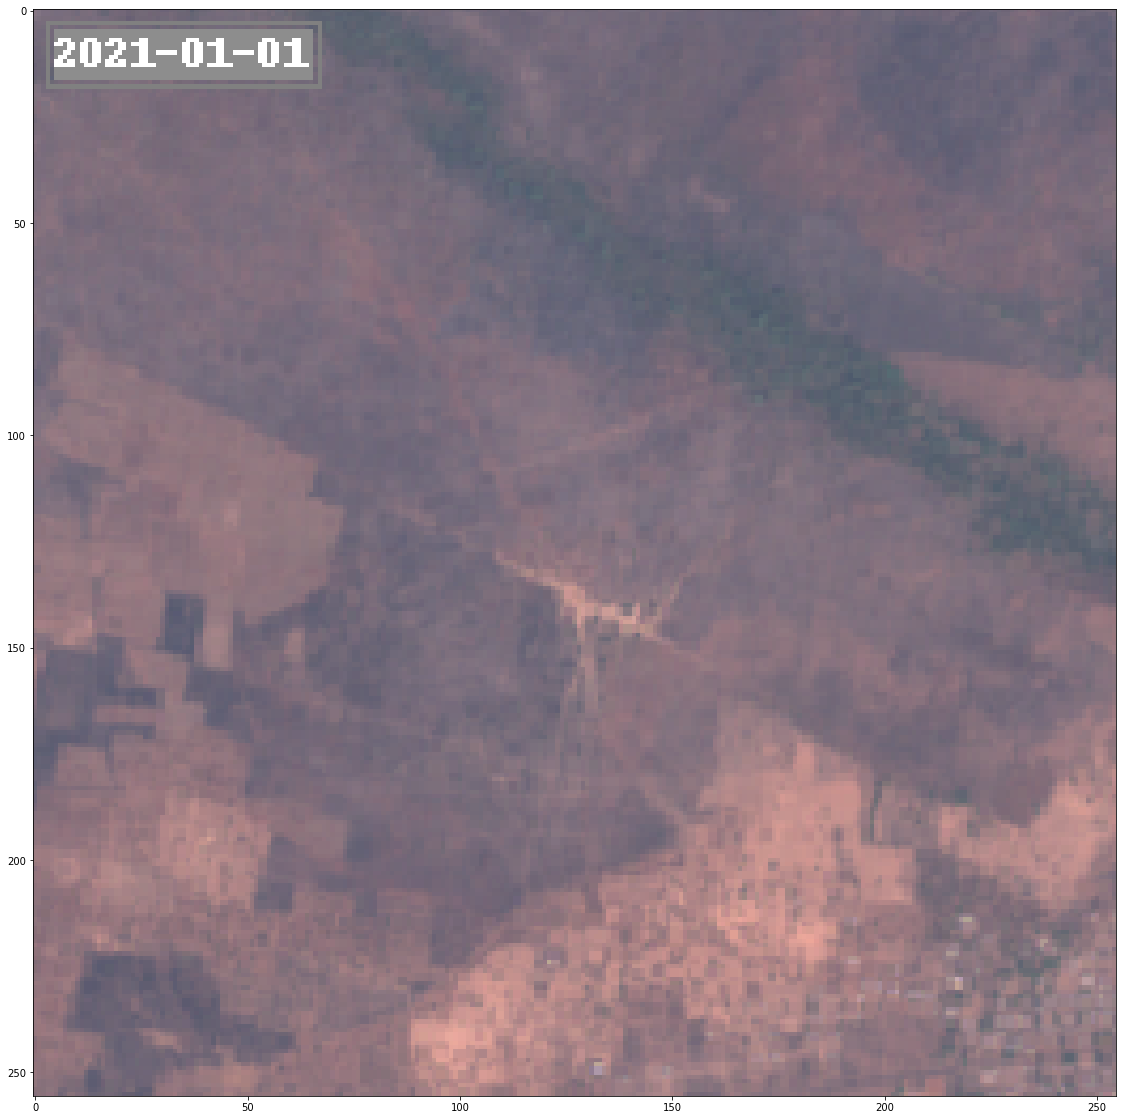

In [46]:
import pylab as plt
plt.figure(figsize=(20,20))
plt.imshow(, interpolation='none')

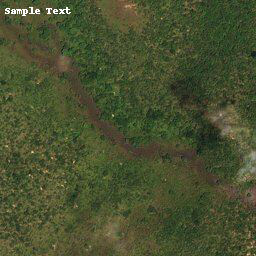

In [107]:
img

In [117]:
(x[:, :, :3] != 0).any(axis=2).sum(), 256 * 256

(65536, 65536)

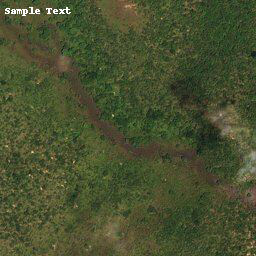

In [116]:
x = np.asarray(img.convert('RGBA')).copy()
x[:, :, 3] = (255 * (x[:, :, :3] != 0).any(axis=2)).astype(np.uint8)
Image.fromarray(x)

# img.putdata(x.reshape(-1, 4).tolist())
# %matplotlib inline

# plt.imshow(x[:, :, 3])

In [75]:
dat = np.asarray(img.getdata())
mask = (dat == 0).all(axis=1)
alpha = np.ones(dat.shape[0]) * 255
alpha[mask] = 0
alpha = alpha.astype(np.uint8)
alpha = Image.new("L", img.size, alpha)

SystemError: new style getargs format but argument is not a tuple

In [76]:
Image.new?

Signature: Image.new(mode, size, color=0)
Docstring:
Creates a new image with the given mode and size.

:param mode: The mode to use for the new image. See:
   :ref:`concept-modes`.
:param size: A 2-tuple, containing (width, height) in pixels.
:param color: What color to use for the image.  Default is black.
   If given, this should be a single integer or floating point value
   for single-band modes, and a tuple for multi-band modes (one value
   per band).  When creating RGB images, you can also use color
   strings as supported by the ImageColor module.  If the color is
   None, the image is not initialised.
:returns: An :py:class:`~PIL.Image.Image` object.
File:      ~/miniconda3/lib/python3.7/site-packages/PIL/Image.py
Type:      function


In [39]:
draw.rectangle?

Signature: draw.rectangle(xy, fill=None, outline=None, width=0)
Docstring: Draw a rectangle.
File:      ~/miniconda3/lib/python3.7/site-packages/PIL/ImageDraw.py
Type:      method


In [27]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

img = Image.open("test.png")
draw = ImageDraw.Draw(img)
# font = ImageFont.truetype(<font-file>, <font-size>)
# font = ImageFont.truetype("sans-serif.ttf", 16)
# draw.text((x, y),"Sample Text",(r,g,b))
draw.text((5, 5),"Sample Text",(255,255,255))
img.save('sample-out.jpg')

In [9]:
s2 = get_s2_files(geom, start, end)

In [ ]:
import ee
import datetime
import shutil
import imageio
import requests
import numpy as np
from retry import retry
from functools import partial
import matplotlib as mpl


ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

def get_s2_files(geometry, start, end):
# create a combined filter from one bounds filter
    # and a timing filter
    criteria = ee.Filter.And( ee.Filter.bounds(geometry), 
                              ee.Filter.date(start, end))

    # load s2 and s2cloud image collection
    s2 = ee.ImageCollection('COPERNICUS/S2')
    s2_files = s2.filter(criteria).aggregate_array('system:index').getInfo()
    
    return s2_files


# @retry(tries=10, delay=1, backoff=2)
def download_image(s2_file, geometry, field_name):
    
    image = ee.Image('COPERNICUS/S2/%s'%s2_file)#.filterMetadata('PRODUCT_ID', 'equals', s2_file).first()
    
    
    url = image.getDownloadURL({
        'region': geometry,
        'scale': 10, 
        'format': 'GEO_TIFF',
        'bands': ['B4', 'B3', 'B2']
    })
    
    g = gdal.Open('/vsicurl_streaming/' + url)
    if g is None:
        print(url)
        raise
    else:
        arr = g.ReadAsArray()

    epsg_code = 3857
    ds = gdal.Warp('', g, format = 'MEM', dstSRS='EPSG:%d'%epsg_code, srcNodata=0, dstNodata=0)
    geo_trans = ds.GetGeoTransform()
    
    x_min = geo_trans[0]
    y_min = geo_trans[3]
    x_max = geo_trans[0] + ds.RasterXSize * geo_trans[1]
    y_max = geo_trans[3] + ds.RasterYSize * geo_trans[5]
    
#     inProj  = Proj(init='epsg:%d'%epsg_code)
#     outProj = Proj(init='epsg:4326')
    
    coords = np.array([[x_min, y_min], [x_max, y_max]])
    
    x_coords = [x_min, x_max]
    y_coords = [y_min, y_max]
    
    transformer = Transformer.from_crs('epsg:%d'%epsg_code, 'epsg:4326')
    (x_min, x_max), (y_min, y_max) = transformer.transform(x_coords,y_coords)
    
    bounds = ((x_min, y_max), (x_max, y_min))
    # bounds = ((y_max, x_min), (y_min, x_max))
    arr = np.clip(ds.ReadAsArray() / 10000 * 256 * 4, 0, 255).astype(np.uint8).transpose(1,2,0)
    im = Image.fromarray(arr)
    date = '-'.join([s2_file[:4], s2_file[4:6], s2_file[6:8]])
    fname = "./data/S2_thumbs/S2_%s.png"%date
    im.save(fname)
    
    home = os.getcwd()
    cwd = '/files/' + '/'.join(home.split('/')[3:])
    base_url = my_map.window_url.split('/lab/')[0] + cwd
    url = base_url + '/data/S2_thumbs/S2_%s.png'%date
    print(url)
    print(bounds)
    image = ImageOverlay(
        url=url,
        bounds = bounds,
        # name = "S2_%s.png"%date
    )
    my_map.add_layer(image)   
    
#     print(ds.GetGeoTransform())
#     print(ds.GetProjection())
#     print(ds.ReadAsArray().shape)
#     r = requests.get(url, stream=True)
#     print(url)
#     if r.status_code != 200:
#         r.raise_for_status()
#     filename = './data/S2_thumbs/S2_%s_%s.tif'%(s2_file, field_name)
#     with open(filename, 'wb') as out_file:
#         shutil.copyfileobj(r.raw, out_file)

    
#     image = image.visualize(bands = ['B4', 'B3', 'B2'], min=0, max=2500)
#     url = image.getThumbURL({
#           'region': geometry,
#           'dimensions': '256x256',
#           'format': 'png'})
#     content = imageio.imread(url)
#     arr = np.asarray(content)
    
#     date = '-'.join([s2_file[:4], s2_file[4:6], s2_file[6:8]])
#     plt.figure()
#     plt.imshow(arr)
#     date = '-'.join([s2_file[:4], s2_file[4:6], s2_file[6:8]])
#     plt.text(180, 20, '%s'%date, color = 'red', bbox={'facecolor':'w', 'alpha':0.5, 'pad':5})
#     filename = './data/S2_thumbs/S2_%s_%s.png'%(s2_file, field_name)
#     plt.axis('off') 
#     plt.savefig(filename, dpi=100, bbox_inches='tight', pad_inches=0)
#     plt.close()
    
    return arr

def get_s2_over_field(field_name, geom, start, end):
    s2_files = get_s2_files(geom, start, end)
    par = partial(download_image, geometry=geom, field_name = field_name)
    with ThreadPoolExecutor() as executor:
        result = executor.map(par, s2_files)
    result = np.array([i for i in result])
    return result, s2_files

field_name = '1029ZIN'
start = '2021-01-01'
end = '2021-12-31'
geom = ee.Geometry.Point(-0.615656152367592, 9.38136229854884).buffer(1000)
# ret, s2_files = get_s2_over_field(field_name, geom, start, end)
s2_files = get_s2_files(geom, start, end)
import time
for s2_file in s2_files:
    download_image(s2_file, geometry=geom, field_name = field_name)
    # time.sleep(0.1)

''

In [34]:
r = requests.get('http://ecn.t3.tiles.virtualearth.net/tiles/a0333311312003130.png?g=1', stream = True)
filename = 'test.png'#%(s2_file, field_name)
with open(filename, 'wb') as out_file:
    shutil.copyfileobj(r.raw, out_file)

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams['axes.xmargin'] = 0
%matplotlib inline

dates = ['-'.join([i[:4], i[4:6], i[6:8]]) for i in s2_files]
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9, 6))
# title = ax.text(200, 20, '%s'%dates[0], color = 'red')

title = ax.text(0.85,0.9, "", bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
                transform=ax.transAxes, ha="center")

def update(i):
    date, arr = dates[i], ret[i]
    title.set_text('%s'%date)
    rgb = np.clip(arr.transpose(1,2,0)/10000*4, 0, 1)
    ax.imshow()
plt.axis('off') 
ani = animation.FuncAnimation(fig, update, frames=len(dates), interval=500, blit=False, repeat=False)
ani.save('movie.gif', dpi=100)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

img = [] # some array of images
frames = [] # for storing the generated images
dates = ['-'.join([i[:4], i[4:6], i[6:8]]) for i in s2_files]

fig = plt.figure()
for i in range(len(ret)):
    img = plt.imshow(ret[i],animated=True)
    plt.title(dates[i])
    frames.append([img])
    
ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True,
                                repeat_delay=1000)
ani.save('movie.gif')
plt.show()

In [ ]:
def mask_cloud(image):
    MAX_CLOUD_PROBABILITY = 40
    clouds = ee.Image(image.get('cloud_probability')).select('probability')
    isNotCloud = clouds.lt(MAX_CLOUD_PROBABILITY)
    return image.updateMask(isNotCloud).addBands(clouds)

def loadS2toa(geometry, start, end):

    # create a combined filter from one bounds filter
    # and a timing filter
    criteria = ee.Filter.And( ee.Filter.bounds(geometry), 
                              ee.Filter.date(start, end))

    # load s2 and s2cloud image collection
    s2 = ee.ImageCollection('COPERNICUS/S2');
    s2Clouds = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY');
    # apply the filter to both collection
    s2 = s2.filter(criteria);
    s2Clouds = s2Clouds.filter(criteria);
    # inner join to get cloud mask for every s2 image
    # joinCondition = ee.Filter.equals({'leftField': 'system:index', 'rightField': 'system:index'});
    joinCondition = ee.Filter.equals(leftField = 'system:index', rightField = 'system:index')
    # adding the cloud mask from s2cloud image colleciton to 
    # s2 image collection as a property
    s2WithCloudMask = ee.Join.saveFirst('cloud_probability').apply(s2, s2Clouds, joinCondition)
    # cast the joned results to image collection
    # and apply the cloud mask
    s2 = ee.ImageCollection(s2WithCloudMask).map(mask_cloud)
    return s2

def get_ndvi(image):
    ndvi = image.normalizedDifference(['B8A', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

def reduce_over_geom(image, geom):
    ret = image.reduceRegion(reducer = ee.Reducer.mean(), geometry = geom.buffer(10), scale=10)
    return ee.Feature(None, ret)

from functools import partial
geom = ee.Geometry.Point(9.380538956561468, -0.6137537956237794)
s2 = loadS2toa(geom, '2021-01-01', '2021-12-31')
s2 = s2.map(get_ndvi)
par = partial(reduce_over_geom, geom = geom)
s2_ndvis = s2.select('NDVI').map(par)
feats = s2_ndvis.getInfo()['features']

s2_ndvis = []
dates = []
for i in feats:
    s2_id = i['id']
    date = datetime.datetime.strptime(s2_id.split('_')[0], '%Y%m%dT%H%M%S')
    s2_ndvi = i['properties']['NDVI'] if 'NDVI' in i['properties'] else np.nan
    s2_ndvis.append(s2_ndvi)
    dates.append(date)

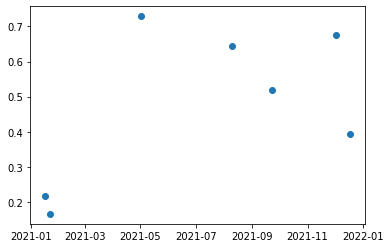

In [2]:
import pylab as plt
plt.plot(dates, s2_ndvis, 'o')

In [1]:
from osgeo import gdal
g = gdal.Open('/vsicurl/https://gws-access.jasmin.ac.uk/public/nceo_ard/Ghana/S1/1056ZIN/1056ZIN.vrt')

In [2]:
data = g.ReadAsArray()

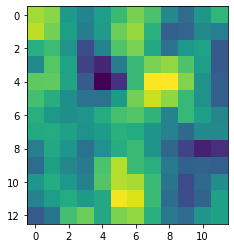

In [3]:
import pylab as plt
plt.imshow(data[0])